# Reinforcement Learning

### Author: Hyungjoo Kim
### All data was provided by University College London, Departmemt of Computer Science, Reinforcement Learning Module
### Supervisor: Hado Van Hasselt, Matteo Hessel, and Diana Borsa

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms (without running experiments or extensive calculations)

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [1]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#009988', '#0033ff', '#993388', '#ee6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=50,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1
**[8 pts]** Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):

  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.name = name 
    self.reset()
    self._bonus_multiplier = bonus_multiplier   # bonus_multiplier (c) is a hyperprameter from lecture 2

  def step(self, previous_action, reward):
    if previous_action is not None:
        self.num_of_times[previous_action] += 1
        q_a = self.action_value[previous_action]
        n_a = self.num_of_times[previous_action]
        r = reward
        self.action_value[previous_action] += (r - q_a) / n_a
    
    t = np.sum(self.num_of_times)
    upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
    upper_bound[np.isnan(upper_bound)] = 0
    ucb_a_t = self.action_value + upper_bound
    optimal_a_t = argmax(ucb_a_t)

    return optimal_a_t
    
  def reset(self):
    self.num_of_times = np.zeros(self._number_of_arms)
    self.action_value = np.zeros(self._number_of_arms)

## Q2
**[8 pts]** Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):

  def __init__(self, name, number_of_arms, epsilon):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = name 
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
        self.num_of_times[previous_action] += 1
        q_a = self.action_value[previous_action]
        n_a = self.num_of_times[previous_action]
        r = reward
        self.action_value[previous_action] += (r - q_a) / n_a

    try:
        if np.random.random() < self._epsilon:
            a = np.random.randint(self._number_of_arms)
        else:
            a = argmax(self.action_value)
    except:
        if np.random.random() < self._epsilon(self.num_of_times.sum()):
            a = np.random.randint(self._number_of_arms)
        else:
            a = argmax(self.action_value)

    action = a
    return action

  def reset(self):
    self.num_of_times = np.zeros(self._number_of_arms)
    self.action_value = np.zeros(self._number_of_arms)

## Q3
**[12 pts]** Implement a softmax REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
class REINFORCE(object):

  def __init__(self, name, number_of_arms, step_size, baseline):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self._baseline = baseline
    self.name = name 
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
        self.num_of_times += 1
        self.average_reward += self._baseline * (reward - self.average_reward) / self.num_of_times
        if self._baseline:
            reward -= self.average_reward
            
        for action in range(number_of_arms):
            if action == previous_action:
                self.preference[action] = self.preference[action] + 2 * self._lr * reward * (1 - self.policy[action]) 
            else:    
                self.preference[action] = self.preference[action] - 2 * self._lr * reward * self.policy[action] 
                
        self.policy = self.preference**2 / np.sum(self.preference**2)
    return np.random.choice(np.arange(self._number_of_arms), p = self.policy) 
        
  def reset(self):
    self.num_of_times = 0
    self.average_reward = 0
    self.preference = np.ones(self._number_of_arms)
    self.policy = self.preference**2 / np.sum(self.preference**2)

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE without baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

<ipython-input-199-9d1cc86e66ce>:19: RuntimeWarning: divide by zero encountered in double_scalars
  epsilon=lambda t: 1./t),
<ipython-input-199-9d1cc86e66ce>:23: RuntimeWarning: divide by zero encountered in double_scalars
  epsilon=lambda t: 1./t**0.5),
<ipython-input-194-8282d514a1dd>:18: RuntimeWarning: divide by zero encountered in log
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-194-8282d514a1dd>:18: RuntimeWarning: invalid value encountered in sqrt
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-194-8282d514a1dd>:18: RuntimeWarning: invalid value encountered in true_divide
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-194-8282d514a1dd>:18: RuntimeWarning: divide by zero encountered in true_divide
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)


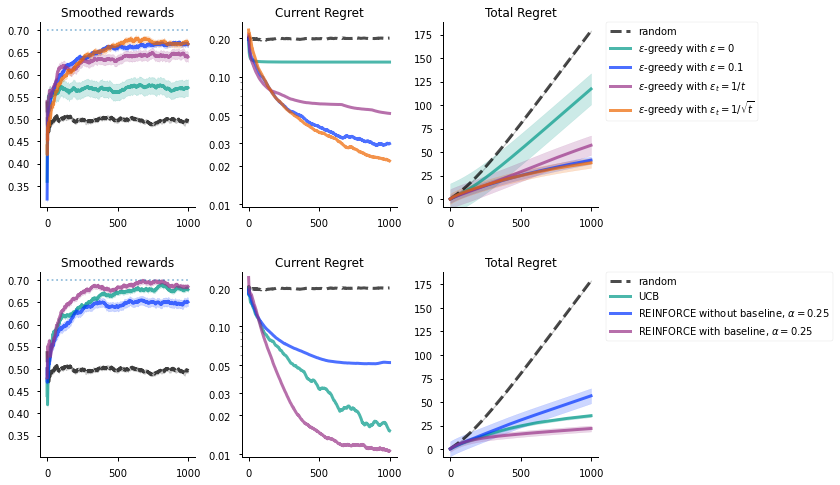

In [200]:
experiment1.show()

## Q5
(Answer inline in the markdown below each question, **within this text cell**.)

**[5pts]** For the best two algorithms from the above plots, explain whether
we would in general expect this algorithm to do well, and why.

The best two algorithms are the Upper Confidence Bound (UCB) and REINFORCE with baseline in the above Figures because it can be seen that the best algorithm can be determined by higher rewards and lower current/total regret. Their concepts are based on the policy gradients and are guaranteed to the logarithm function in total regret, rather than a linear. Furthermore, UCB is not a random algorithm, it is a deterministic algorithm and adds the confidence bound level, and REINFORCE with baseline algorithm does not affect the expected policy gradient update, which means that it does not directly depend on the function of parametric policy and the selecting current action. Therefore, the aim of Reinforcement learning is trying to compute exploration and exploitation for minimising the total regret and maximising the rewards, which is corresponding to the UCB and REINFORCE with baseline ($\alpha$=0.25) algorithms.





**[5pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms.

*The best ranking of the $\epsilon$-greedy algorithms during the 1000 number of steps:*

**1st:** $\epsilon_t=1/\sqrt{t}$ 

**2nd:** $\epsilon=0.1$

**3rd:** $\epsilon_t=1/{t}$

**4th:** $\epsilon=0.$

Epsilon is used based on the $q$ values already experienced when executing a particular action. In the case of the pure greedy method ($\epsilon=0.$), exploration problems arise because it always chooses the highest $q$ value out of all $q$ values for a particular state, which can easily be trapped in a specific region at local optima. Therefore, epsilon would be introduced to randomness to solve this problem. For example, if $\epsilon=0.1$, it can select a random action with a 0.1 probability regardless of the actual $q$ value, and the remaining 0.9 probability is chosen on argmax(Q). This means that the epsilon depends on how randomly action would be taken. Furthermore, the improvement of the $\epsilon$-greedy method is also called the decay-$\epsilon$-greedy method. It is the same as the polynomial schedule presented in question 2 ($\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$). This equation decreases rapidly when $\eta$ closes to zero, but over time, it decreases considerably slow when $\eta$ close to one. This allows the model to explore more freely with a high probability in the initial training process and continuously allows the selection of the optimal value in all training processes. However, the performance of $\epsilon_t=1/{t}$ is not better than $\epsilon_t=0.1$ because the value of $\epsilon_t=1/{t}$ is bigger than $\epsilon_t=0.1$.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [21]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

<ipython-input-12-9d1cc86e66ce>:19: RuntimeWarning: divide by zero encountered in double_scalars
  epsilon=lambda t: 1./t),
<ipython-input-12-9d1cc86e66ce>:23: RuntimeWarning: divide by zero encountered in double_scalars
  epsilon=lambda t: 1./t**0.5),
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: divide by zero encountered in log
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: invalid value encountered in sqrt
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: invalid value encountered in true_divide
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: divide by zero encountered in true_divide
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)


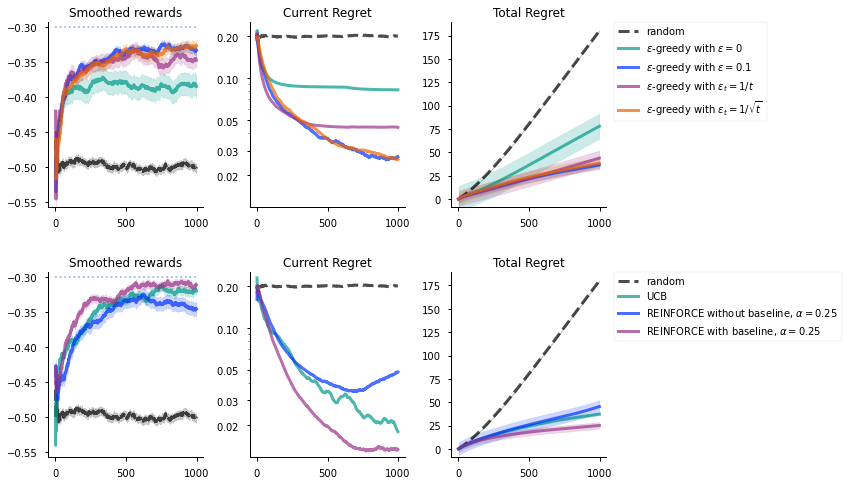

In [22]:
experiment2.show()

## Q6
**[8pts]** For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

**$\epsilon$-greedy with $\epsilon = 0.$:** This algorithm has no value of $\epsilon$, which means a greedy algorithm. It always compares a reward at the previous step and at the current step, and immediately select a better reward (selecting the action with the highest estimated value) to improve the algorithm, so this algorithm has improved because the rewards are reduced in case of failure. 

**$\epsilon$-greedy with $\epsilon = 0.1$, and $\epsilon_t=1/{t}$:** In probability $\epsilon$-greedy, it is randomly uniform to sample an action, whereas, in probability ($1-\epsilon$), the action is selected when the estimated value is the highest. Therefore, the $\epsilon$-greedy algorithm has significantly improved because incorrect action values have initially reduced the rewards, which results in higher regrets than in the previous steps in exploration, but the reward can be higher in several steps (=1,000) as regret would be reduced in exploitation because it is easy to find better action randomly based on the previous failure cases.

**$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$:** The principle of this algorithm is the same as the above $\epsilon$ algorithms. However, the $\epsilon_t$ is a polynomial decay, so decline of the current regret is slower than other $\epsilon$ algorithms and if there have more the number of steps, the performance will be more efficient.

**UCB:** It similarly reduces the reward for the incorrect actions, but the regret is almost similar to Experiment 1 because it defines confidence bound and runs exploration in a favourable way rather than a random way at each step where fewer samples are received, which results in minimising regret. According to UCB equation, 'c' (bonous multiplier) refers to the confidence level and uses a natural logarithm for the exploration and exploitation, so all actions are selected and computed that the performance is similar. 

**REINFORCE with baseline ($\alpha=0.25$):** Reinforce through square-max policy parameterization varies in performance depending on whether there is a baseline or not, but the expected update of the algorithm (reward) does not affect the gradient-bandit algorithm (square-max action preferences based on the stochastic gradient ascent) because it is immediately applied to a new level using the average of the rewards. 

**REINFORCE without baseline ($\alpha=0.25$):** REINFORCE without baseline means that the baseline is omitted that the average reward was taken to be constant zero. However, The principle of REINFORCE without baseline is similar to the REINFORCE with baseline, which means that it is immediately applied to a new level without a baseline, so the performance of this algorithm is similar to experiment 1 (the performance for finding the optimal action is degraded compared with REINFORCE with baseline).

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [23]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [24]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

<ipython-input-23-a204ced620a3>:14: RuntimeWarning: divide by zero encountered in double_scalars
  epsilon=lambda t: 1./t**0.5),
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: divide by zero encountered in log
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: invalid value encountered in sqrt
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: invalid value encountered in true_divide
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: divide by zero encountered in true_divide
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)


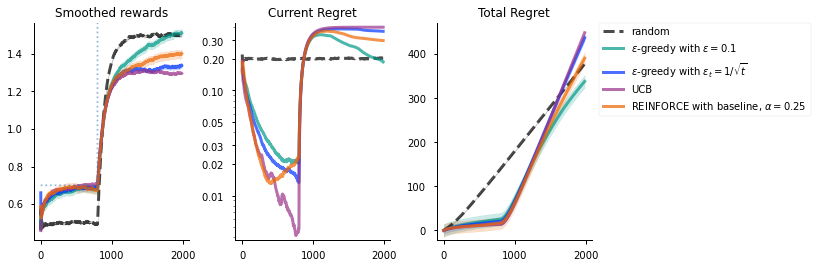

In [25]:
experiment3.show()

<ipython-input-23-a204ced620a3>:14: RuntimeWarning: divide by zero encountered in double_scalars
  epsilon=lambda t: 1./t**0.5),
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: divide by zero encountered in log
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: invalid value encountered in sqrt
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: invalid value encountered in true_divide
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)
<ipython-input-8-8282d514a1dd>:18: RuntimeWarning: divide by zero encountered in true_divide
  upper_bound = self._bonus_multiplier * np.sqrt(np.log(t) / self.num_of_times)


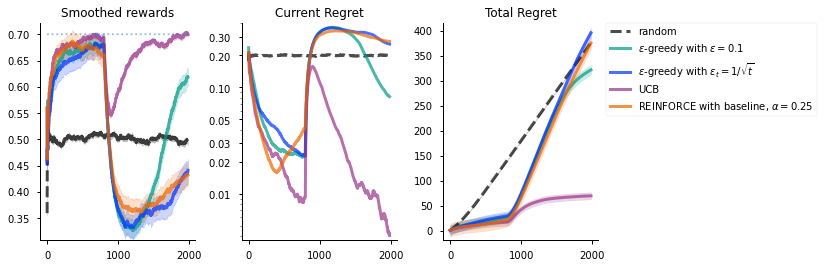

In [26]:
experiment4.show()

## Q7

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

**[8 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> **The best ranking of the current-regret in experiment 3:**

> $\epsilon_t=0.1$  >  REINFORCE with baseline ($\alpha=0.25$) >  $\epsilon_t=1/\sqrt{t}$ >  UCB

> **$\epsilon$-greedy algorithm:**  As mentioned in question 5, $\epsilon$-greedy algorithm ($\epsilon = 0.1$) and ($\epsilon_t = 1/\sqrt{t}$) choose exploration with a small probability of epsilon and work randomly regardless of action-value estimates without taking advantage of what they have learned so far. Furthermore, after 800 steps, it uses failure cases when it decides the exploitation because $\epsilon$-greedy algorithm exploits estimate action values using higher reward cases. The ($\epsilon = 1/\sqrt{t}$) algorithm is a polynomial decay, so this curve changes slowly more than the ($\epsilon = 0.1$) algorithm after 800 steps.

> **UCB:** The algorithm of UCB always balances exploration and exploitation by setting confidence bound levels as mentioned Q6 ('Hoeffding inequality' limits the current regret), so the current regret curve shows that although the failure reward is twice the success rewards, the certainty of the action value before 800 steps does not change after 800 steps. Therefore, this algorithm has less impact than other algorithms because it does not consider to use rewards of the failure case, even if it recognises them.

> **REINFORCE with baseline ($\alpha=0.25$):** As mentioned in question 6, the algorithm basically samples rewards by gradient Bandit that it is still able to extract a variety of reward samples, and the preference for higher rewards (failure cases) increases the likelihood of choosing failures in the next steps, as it prefers higher rewards by baseline after 800 steps. Therefore, the current regret curve looks decreasing slowly because reward is changed at 800 steps and apply new baseline (gradient ascent) on the expected rewards.


**[8 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> **The best ranking of the current-regret in experiment 4:**

> UCB  >  $\epsilon_t=0.1$  >  REINFORCE with baseline ($\alpha=0.25$) >  $\epsilon_t=1/\sqrt{t}$ 

> **$\epsilon$-greedy algorithm:** $\epsilon$-greedy algorithm approaches mostly choose the action with the highest estimated reward, and even if the experiment changes, the action is randomly selected regardless of the action-value estimate, so they quickly find optimal actions and the current-regret curve is similar to experiment 1 (only the criteria for success and failure is converse and reward value is the same), but $\epsilon_t=1/\sqrt{t}$ algorithm is only slow to recover because of the polynomical decay.

> **UCB:** UCB algorithm changes the balance between exploration and exploitation as it collects more knowledge of the environment, rather than choosing a selected action by a probability, so the current regret curve changes dramatically after 800 steps, but only the criteria for success and failure is converse and reward value is the same, so the curve is similar to the experiment 1. 

> **REINFORCE with baseline ($\alpha=0.25$):** The REINFORCE with baseline algorithm generally estimates only the first state function learned because the baseline does not change the expected value of the update and affects the variance so that the current-regret curve changes less after 800 steps (only the criteria for success and failure is converse and reward value is the same) because this estimate establishes only the criteria for the next steps, but does not affect the assessment of the action because it is done before the action of the transition.

**[4 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> We already understood the best performance that the current-regret curve is minimised when maximising rewards. In experiment 4, the criterion for reward is only the opposite of Experiment 1, so it can be considered similarly, which means the bound is well balanced to minimise the regrets between exploration and exploitation. However, the UCB algorithm in Experiment 3 prefers rewards for failures because the rewards are doubled in the case of failure, so the algorithm knows that the failure case should be used and minimises regret when maximizing rewards, but it does not consider.
 

**[4 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify the $\epsilon$-greedy algorithm implemented above to deal with that better?  Be specific and concise.

> Value Differenced Based Exploration (VDBE) [1] basically operates $\epsilon$-greedy by adjusting $\epsilon$ (independence of error of the value function), which is the state-dependent exploration probability, rather than passively control tuning values. This allows agents to explore deeper from the beginning of the learning process as perceive as a huge change in the value function when their knowledge of the environment is unclear. The state search probability must decrease as the agent's knowledge becomes clear and the value may be perceived as little change.

> [1] M. Tokic, "Adaptive $\epsilon$-greedy Exploration in Reinforcement Learning Based on Value Differences", *University of Ulm*, Germany, pp. 4-5.

**[8 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> To solve this problem, a discounted UCB and *sliding-window* UCB algorithm are suggested [2]. The discounted UCB algorithm applies a discount rate ($\gamma \in [0,1]$) to estimate expected rewards that average previous rewards and focus on a current observation. Furthermore, the *sliding-window* UCB algorithm is a method of using the local average empirical rewards by applying only the last step instead of averaging the rewards for all pasts by the discount rate.

> [2] A. Garivier and E. Moulines, "On Upper-Confidence Bound Policies for Non-Stationary Bandit Problems", *Institut Telecom*, Paris, May, 2008.

# C) Reasoning about algorithms

## Q8

Consider the UCB algorithm. Suppose we have two actions, $a$ and $b$. Consider the initial exploration bonus for each to be infinite, as long as we have not selected the corresponding action, so that the algorithm first selects each action at least once.

Suppose action $a$ yields a Bernoulli random reward with $p(R=1 \mid a) = 1/3$ and $p(R=0 \mid a) = 2/3$.  Action $b$ also yields a Bernoulli random reward, but with $p(R=1 \mid b) = 2/3$ and $p(R=0 \mid b) = 1/3$.

**[7 pts]** What is the probability (before seeing any data) of selecting action $a$ on the third time step (at which point we will have selected both $a$ and $b$ exactly once)?  (Break ties uniformly, if relevant.)

> UCB is not a random algorithm, it is a deterministic algorithm and adds the bound to each of two actions. This is a common format for hyperparameter $𝑐$ multiplication with the bound. Let's imagine the specific case that action $𝑎$ was selected in the first step and action $𝑏$ was selected in the second step. In this specific case, UCB does not actually matter to select the next action in the third step because both actions ($𝑎$ and $𝑏$) are selected exactly at least once in the first and second step, respectively. It means that the bound for these actions are exactly the same, so adding the same number of actions to estimate that does not really change which action will be greedy. Therefore, UCB does not select the action $𝑎$ in this case, which means a probability of selecting action $𝑎$ on the third time step would be 0 because the action b was selected in the second step. On the other hand, let's imagine another case conversely that action $𝑏$ was selected in the first step and action $𝑎$ was selected in the second step. Approach the same above principles, action $𝑎$ will be selected in the third step that a probability would be 1.

## Q9

Consider a bandit with two arms, $a$ and $b$.  So far, we have seen the following actions and rewards, on time steps $t=1$ and $t=2$:
\begin{align*}
t=1\,:\qquad A_1=a~,~ R_1=0\\
t=2\,:\qquad A_2=b~,~ R_2=1 
\end{align*}
The rewards are known to be Bernoulli random variables (so $R_t \in \{0, 1\}$) with unknown means.

Consider a Thompson sampling algorithm to select actions, with a uniform Beta prior at time $t=0$ such that the probability density functions for the expected reward for both actions before seeing any data (at time $t=0$) are defined by $p(E[R] = x\mid a) = 1$, for all $x\in[0,1]$, and all $a$.


**[7 pts]** What is the probability under Thompson sampling of $A_3 = a$? Show your calculations, but keep it concise.

> As mentioned in question 9, actions and rewards are already given in the first and second step and the beta distribution is uniform between 0 and 1, so the posterior distribution of Thompson sampling in this specific case can be represented as:
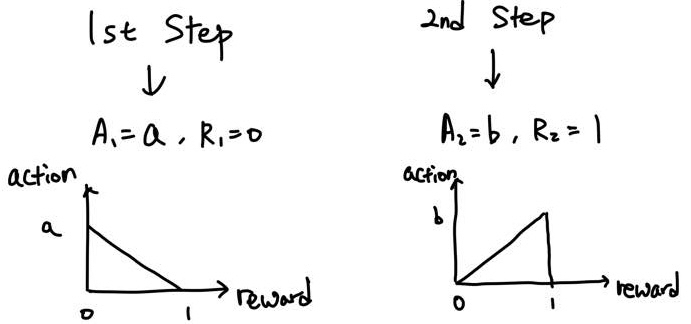

>From now, we can consider the above belief distributions and the likelihood that action $a$ is optimal compare with the action $b$. Therefore, action $a$ between 0 and 1, and action $b$ between 0 and 1 can be possible to select each one of them. Thus, the total possible number of cases have four (0 and 1 for action $a$, and 0 and 1 for action $b$) and action in the third step should be $a$, which means that the probability under Thompson sampling of action $a$ in the third step would be 0.25 [3].

> [3] H. V. Hasselt, "COMP0089: Reinforcement Learning Lecture 2: Exploration and Exploitation", *University College London (UCL)*, 2021.

> (Reminder! - It just my opinion that Prof. Hado explained 0.25 in the lecture broadcast (week 2), but many students are wondering this question is right or not. The question hasn't answered yet in the Q&A channel forum. I think that this question can be possible 0.5 because action $a$ can be possible between 0 and 1. However, I just wrote 0.25 because Prof. Hado explained 0.25 already.)




## Q10

Consider a tabular ergodic MDP, and consider the following algorithm: 

On each time step $t$ we use UCB in the state we are currently in to determine the action to take.  Specifically, use and update the required statistics for UCB locally, for that state. In other words, in each state we update the UCB statistics as if that state is a bandit problem. 

However, instead of averaging the immediate rewards to use as action values, we use one-step Q-learning with a step size $\alpha_t$ to predict action values with some discount $\gamma \in [0, 1]$.

**[8 pts]** Is this algorithm guaranteed to converge to the optimal value function $q_*$ (for any finite MDP with well-defined values, e.g., $\gamma<1$) for an appropriately chosen step size schedule $\{ \alpha_t \}_{t=0}^\infty$?  Prove your answer, but be concise.  (E.g., this proof should not include lengthy calculations, you don't have to specify a concrete step size schedule, etc.)

> **Q-learning estimates the value of the greedy policy** [4]: 

>$q_{t+1}$($S_t, A_t$) = $q_t$($S_t, A_t$) + $\alpha_t$($R_{t+1}$ +  $\gamma$$max_{a'}$$q_t(S_{t+1}, a')$ - $q_t(S_t, A_t)$)


> Yes, it is. Q-learning algorithm possibly takes the best action according to the current estimate as shown in the above equation ($\gamma$$max_{a'}$$q_t(S_{t+1}, a')$). The Q-learning algorithm with a step size ($\alpha$) converges to an optimal value function, q -> $q_*$, as long as each action of each state is performed infinitely because Q-learning algorithm actually does not need the greedy behaviour [4]. In other words, Q-learning algorithm can eventually learn the optimal value function even when it is uniformly random explored over its lifetime. For example, we have random processes and random data, we can consider the doubt that the algorithm actually converges only when it obtains infinite data in the limit. However, in practice, it is no longer necessary to use the policy greedy. This eventually applies to all policy that fully selects all actions (e.g. uniform policy).
Therefore, under this step size condition ($\{\alpha_t \}_{t=0}^\infty$), if there are all steps until the whole step size grows to infinity, the step size is chosen to be such that the state action-value estimate (move far enough) is more optimized to find a new estimate. Thus, this algorithm guaranteed to converge to the optimal value function $q_*$.

>[4] H. V. Hasselt, "COMP0089: Reinforcement Learning Lecture 6: Model-Free Control", *University College London (UCL)*, 2021.